## One class SVM anomaly detection

In [2]:
import numpy as np
from sklearn.svm import OneClassSVM
from scipy.stats import multivariate_normal
from joblib import dump
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from utils import *
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

## Utility functions

In [3]:
def process_signals(error_file, u_file, x_file):
    """
    Processes error_signal and u_signal from CSV files, groups their columns into lists of 4.

    Args:
        error_file (str): Path to the CSV file for error_signal.
        u_file (str): Path to the CSV file for u_signal.

    Returns:
        tuple: Two lists - one for error_signal and one for u_signal, each containing grouped arrays (4 per group).
    """
    # Load the CSV data
    error_signal = np.loadtxt(error_file, delimiter=',')
    u_signal = np.loadtxt(u_file, delimiter=',')
    x_signal = np.loadtxt(x_file, delimiter=',')

    # Initialize lists for storing grouped arrays (4 per group)
    error_not_distracted_list = []
    u_signal_not_distracted_list = []
    x_signal_not_distracted_list = []
    
    # Grouping error_signal in steps of 4
    for i in range(0, error_signal.shape[1], 4):
        scaler = StandardScaler()
        error_group = [scaler.fit_transform(error_signal[:, j].reshape(-1,1)).flatten() for j in range(i, min(i + 4, error_signal.shape[1]))]
        error_not_distracted_list.append(error_group)

    # Grouping u_signal in steps of 4
    for i in range(0, u_signal.shape[1], 4):
        u_group = [scaler.fit_transform(u_signal[:, j].reshape(-1,1)).flatten() for j in range(i, min(i + 4, u_signal.shape[1]))]
        u_signal_not_distracted_list.append(u_group)

    for i in range(0, x_signal.shape[1], 4):
        x_group = [scaler.fit_transform(x_signal[:, j].reshape(-1,1)).flatten() for j in range(i, min(i + 4, x_signal.shape[1]))]
        x_signal_not_distracted_list.append(x_group)

    return error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list

def plot_heatmap(true_labels, predicted_labels):
  plt.figure(figsize=(10, 7))

  cm = confusion_matrix(true_labels, predicted_labels)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=np.arange(cm.shape[1]),
              yticklabels=np.arange(cm.shape[0]))
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

## Read signals from file

In [4]:
# error_not_distracted, u_signal_not_distracted = process_signals(error_file= '/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file='/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv')
error_not_distracted, u_signal_not_distracted, x_signal_not_distracted = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/x.csv')
error_distracted, u_signal_distracted, x_signal_distracted         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/x.csv')

In [5]:
person_idx = 0
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')
tc_test_col = tc_test[:, person_idx]

# combine the entire list in the priors
error_not_distracted_person = np.concatenate(error_not_distracted[person_idx])
u_not_distracted_person = np.concatenate(u_signal_not_distracted[person_idx])
x_not_distracted_person = np.concatenate(x_signal_not_distracted[person_idx])

# X_not_distracted = np.column_stack((error_not_distracted_person[:-1], u_not_distracted_person[:-1], x_not_distracted_person[:-1]))

X_not_distracted = np.column_stack((error_not_distracted_person, u_not_distracted_person))
                                                                                              
error_distracted_person = np.concatenate(error_distracted[person_idx])
u_distracted_person = np.concatenate(u_signal_distracted[person_idx])
x_distracted_person = np.concatenate(x_signal_distracted[person_idx])

# X_test = np.column_stack((error_distracted_person, u_distracted_person, x_distracted_person))
X_test = np.column_stack((error_distracted_person, u_distracted_person))

## Initialise model

In [7]:
# adjust the 'nu' parameter to control the proportion of outliers.
ocsvm = OneClassSVM(kernel='rbf', nu=0.15, gamma='scale')
ocsvm.fit(X_not_distracted)

# Step 4: Predict on Mixed Samples
predictions = (ocsvm.predict(X_test) == -1).astype(int)

# Step 5: Interpret Results
distracted_samples = X_test[predictions == -1]
not_distracted_samples_detected = X_test[predictions == 1]

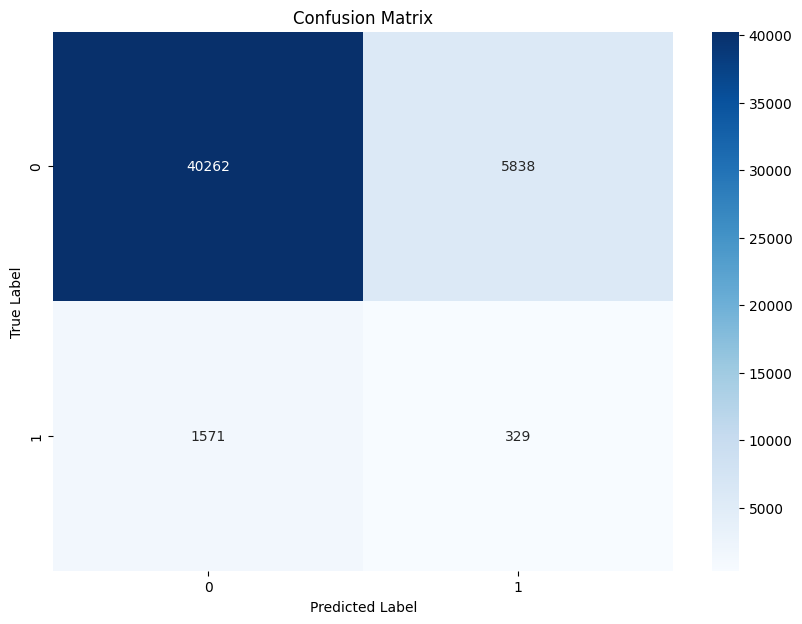

F1 Score:  0.08156687740176026
Precision:  0.053348467650397274
Recall:  0.1731578947368421


In [8]:
# generate confusion matrix using: tc_test_col, predictions
plot_heatmap(np.concatenate(tc_test[:,:4]), predictions)

# print f1 score, precision and recall
print("F1 Score: ", f1_score(np.concatenate(tc_test[:,:4]), predictions))
print("Precision: ", skm.precision_score(np.concatenate(tc_test[:,:4]), predictions))
print("Recall: ", skm.recall_score(np.concatenate(tc_test[:,:4]), predictions))


## Visualise the decision boundaries

/tmp/ipykernel_1821941/631515415.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


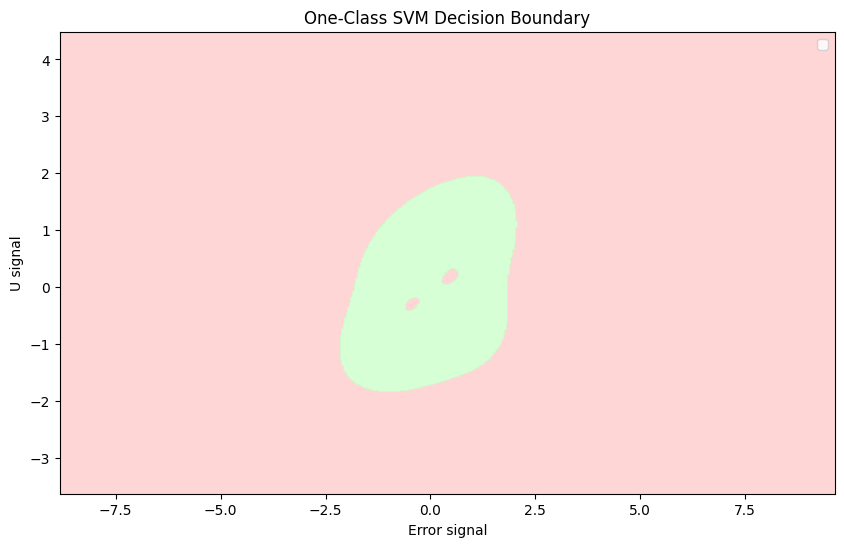

In [9]:
# Step 2: Create a Grid for Visualization
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Step 3: Predict on the Grid
grid_predictions = ocsvm.predict(grid_points)
grid_predictions = grid_predictions.reshape(xx.shape)

# Step 4: Predict on Test Data
predictions = (ocsvm.predict(X_test) == -1).astype(int)
distracted_samples = X_test[predictions == 1]
not_distracted_samples_detected = X_test[predictions == 0]

# Step 5: Plot the Decision Boundary and Points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, grid_predictions, levels=[-1, 0, 1], alpha=0.8, colors=['#ffcccc', '#ccffcc'])
# plt.scatter(X_not_distracted[:1000, 0], X_not_distracted[:1000, 1], c='blue', label='Not Distracted (Train)')
# plt.scatter(distracted_samples[:1000, 0], distracted_samples[:1000, 1], c='red', label='Distracted (Detected)')
# plt.scatter(not_distracted_samples_detected[:, 0], not_distracted_samples_detected[:, 1], 
#             c='green', label='Not Distracted (Detected)', marker='x')
plt.title('One-Class SVM Decision Boundary')
plt.xlabel('Error signal')
plt.ylabel('U signal')
plt.legend()
plt.show()

In [14]:
def compute_decision_function(error_signal, u_signal, x_signal, person_idx):
    # combine the entire list in the priors
    error_not_distracted_person = np.concatenate(error_signal[person_idx])
    u_not_distracted_person = np.concatenate(u_signal[person_idx])
    x_not_distracted_person = np.concatenate(x_signal[person_idx])

    # X_not_distracted = np.column_stack((error_not_distracted_person[:-1], u_not_distracted_person[:-1], x_not_distracted_person[:-1]))
    X_not_distracted = np.column_stack((error_not_distracted_person, u_not_distracted_person))

    # Step 1: Train the One-Class SVM
    ocsvm = OneClassSVM(kernel='rbf', nu=0.15, gamma='scale')
    ocsvm.fit(X_not_distracted)

    # Step 2: Create a Grid for Visualization
    x_min, x_max = X_not_distracted[:, 0].min() - 1, X_not_distracted[:, 0].max() + 1
    y_min, y_max = X_not_distracted[:, 1].min() - 1, X_not_distracted[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Step 3: Compute Decision Function on the Grid
    decision_function = ocsvm.decision_function(grid_points)
    decision_function = decision_function.reshape(xx.shape)
    
    return decision_function, xx, yy, ocsvm

def compute_distances_to_boundary(X_test, ocsvm):
    """
    Compute the signed distances of test samples to the decision boundary of a trained One-Class SVM.

    Parameters:
        X_test (numpy.ndarray): The test samples (shape: [n_samples, n_features]).
        ocsvm (OneClassSVM): A trained One-Class SVM model.

    Returns:
        distances (numpy.ndarray): Signed distances of the test samples to the decision boundary.
    """
    # Use the decision_function method to get distances
    distances = ocsvm.decision_function(X_test).ravel()  # Flatten to 1D array
    return distances

def plot_decision_boundary(decision_function, xx, yy):
    # Step 4: Plot the Results
    plt.figure(figsize=(10, 6))
    # Contour: Decision boundary at level 0
    plt.contour(xx, yy, decision_function, levels=[0], linewidths=2, colors='black')
    # Filled Contour: Regions
    plt.contourf(xx, yy, decision_function, levels=np.linspace(decision_function.min(), 0, 10), cmap=plt.cm.PuBu)
    plt.contourf(xx, yy, decision_function, levels=np.linspace(0, decision_function.max(), 10), cmap=plt.cm.Oranges)

    # Plot training data
    # plt.scatter(X_not_distracted[:, 0], X_not_distracted[:, 1], c='blue', label='Training Data (Not Distracted)')
    # # Highlight detected "distracted" and "not distracted" samples
    # plt.scatter(X_test[:, 0], X_test[:, 1], c='white', edgecolors='k', label='Test Data')

    plt.title('One-Class SVM Decision Boundary')
    plt.xlabel('Error signal')
    plt.ylabel('U signal')
    plt.legend()
    plt.show()

## Compute the distances to the decision function boundary

In [9]:
decision_function, xx, yy, ocsvm = compute_decision_function(error_not_distracted, u_signal_not_distracted, x_signal_not_distracted, person_idx=0)

In [10]:
distances = compute_distances_to_boundary(X_test, ocsvm)

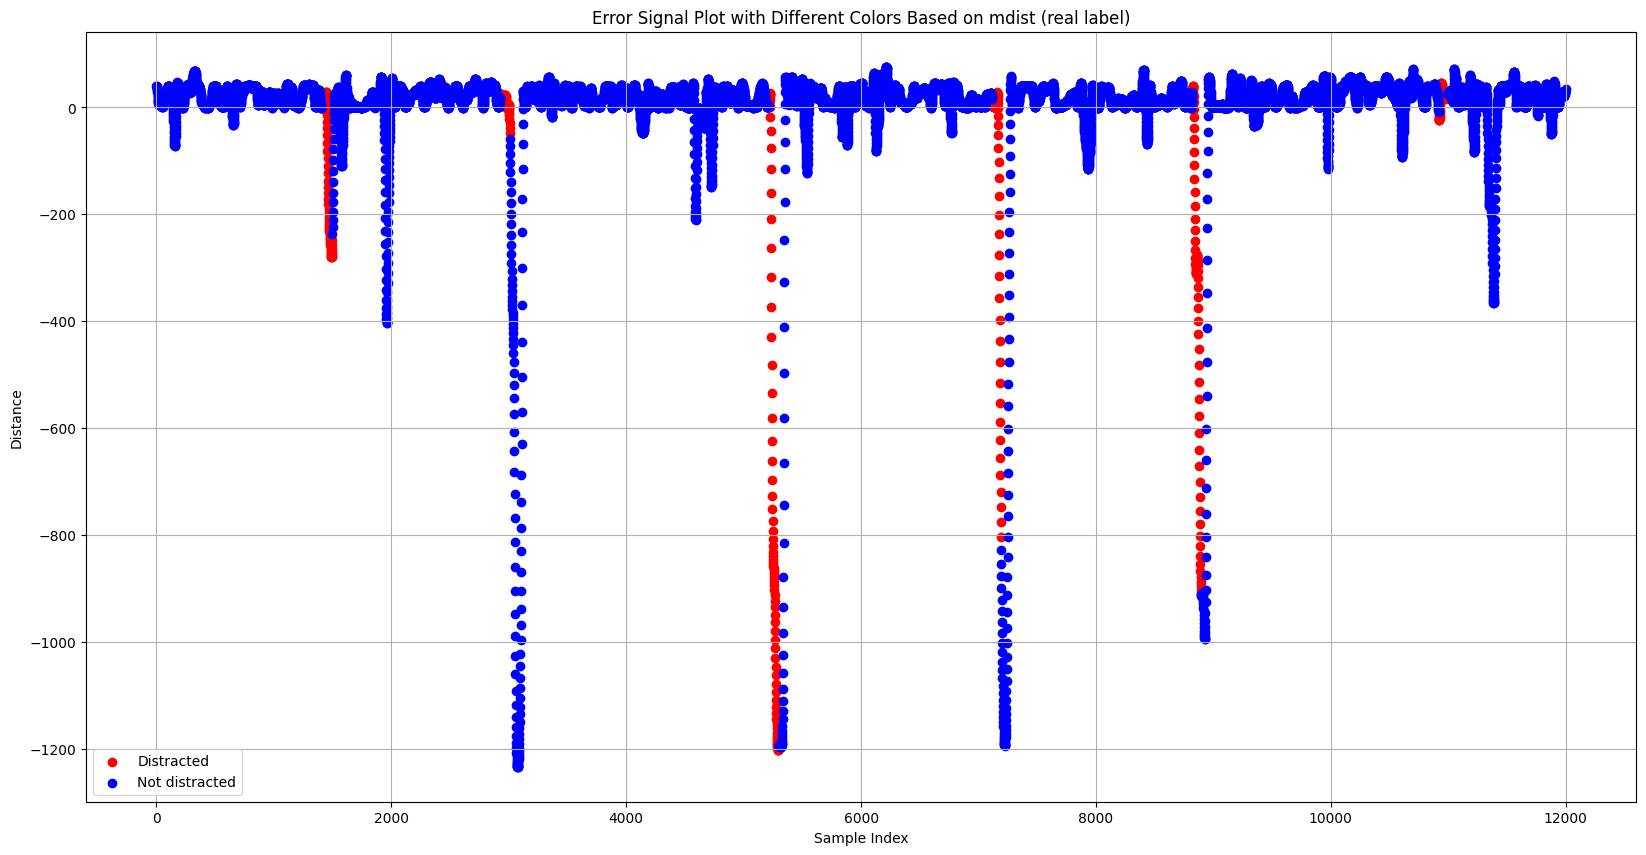

In [11]:
tc_test_col = tc_test[:, 2]
distances_run = distances[12000*2:3*12000]

# Create a mask for tc_test == 1 and tc_test == 0
mask_1 = tc_test_col == 1
mask_0 = tc_test_col == 0

# Plotting
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(distances_run))[mask_1], distances_run[mask_1], color='red', label='Distracted')
plt.scatter(np.arange(len(distances_run))[mask_0], distances_run[mask_0], color='blue', label='Not distracted')
plt.grid()
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Error Signal Plot with Different Colors Based on mdist (real label)')
plt.legend()
plt.show()

/tmp/ipykernel_1821941/1389594127.py:31: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, decision_function, levels=[0], linewidths=1, colors='black', linestyles='-', label='Decision Boundary')


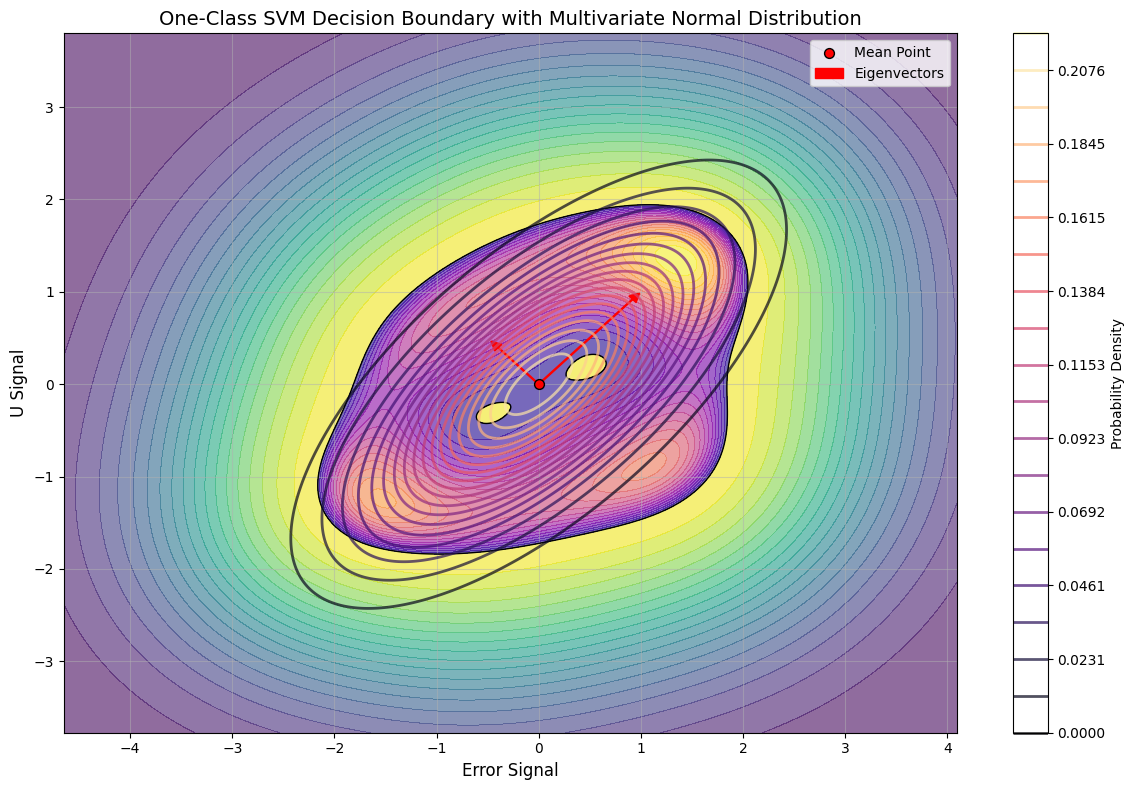

In [19]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary_with_distribution(decision_function, xx, yy, mean, cov):
    """
    Plots the decision boundary for a One-Class SVM along with the multivariate normal distribution,
    highlighting the mean and eigenvectors of the distribution.

    Parameters:
    - decision_function: The computed decision function from the SVM model.
    - xx, yy: Meshgrid points for plotting the decision boundary.
    - mean: Mean of the multivariate normal distribution.
    - cov: Covariance matrix of the multivariate normal distribution.
    """
    # Step 1: Fit a multivariate normal distribution
    rv = multivariate_normal(mean, cov)

    # Step 2: Compute the probability density over the grid
    pos = np.dstack((xx, yy))
    pdf = rv.pdf(pos)

    # Step 3: Compute eigenvalues and eigenvectors for covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.sqrt(eigvals)

    # Step 4: Plot the decision boundary
    plt.figure(figsize=(12, 8))

    # Decision boundary at level 0 (black dashed line, thicker lines)
    plt.contour(xx, yy, decision_function, levels=[0], linewidths=1, colors='black', linestyles='-', label='Decision Boundary')
    
    # Filled contour for decision regions (with more transparent color)
    plt.contourf(xx, yy, decision_function, levels=np.linspace(decision_function.min(), 0, 20), cmap='viridis', alpha=0.6)
    plt.contourf(xx, yy, decision_function, levels=np.linspace(0, decision_function.max(), 20), cmap='plasma', alpha=0.6)

    # Step 5: Overlay the multivariate normal distribution
    # Increase the number of contour levels for better resolution
    pdf_contour = plt.contour(xx, yy, pdf, levels=np.linspace(pdf.min(), pdf.max(), 20), cmap='magma', linewidths=2, alpha=0.7)
    plt.colorbar(pdf_contour, label='Probability Density')

    # Step 6: Highlight the mean point
    plt.scatter(mean[0], mean[1], color='red', edgecolors='k', s=50, label='Mean Point', zorder=5)

    # Step 7: Plot eigenvectors
    for i in range(len(eigvals)):
        plt.arrow(
            mean[0], mean[1], 
            eigvecs[0, i] * eigvals[i], eigvecs[1, i] * eigvals[i], 
            color='red', width=0.01, head_width=0.1, head_length=0.1, 
            label=f'Eigenvectors' if i == 0 else None
        )

    # Step 8: Add labels, legend, and title
    plt.title('One-Class SVM Decision Boundary with Multivariate Normal Distribution', fontsize=14)
    plt.xlabel('Error Signal', fontsize=12)
    plt.ylabel('U Signal', fontsize=12)
    plt.grid(alpha=0.5)

    # Custom legend
    plt.legend(loc='upper right', fontsize=10, frameon=True)

    plt.tight_layout()
    plt.show()

# Updated loop for one person
for person_idx in range(1):
    mean = np.array([7.11965209e-17, 9.31083914e-18])
    cov = np.array([
        [1.00002083, 0.68751437],
        [0.68751437, 1.00002083]
    ])
    decision_function, xx, yy, ocsvm = compute_decision_function(
        error_not_distracted, u_signal_not_distracted, x_signal_not_distracted, person_idx
    )

    # Plot the decision boundary with the multivariate normal distribution, mean, and eigenvectors
    plot_decision_boundary_with_distribution(decision_function, xx, yy, mean, cov)


In [1]:

for person_idx in range(10):
    decision_function, xx, yy, ocsvm = compute_decision_function(error_not_distracted, u_signal_not_distracted, x_signal_not_distracted, person_idx)
    plot_decision_boundary(decision_function, xx, yy)
    # Save the trained One-Class SVM model
    dump(ocsvm, f'ocsvm_model_{person_idx}.joblib')

NameError: name 'compute_decision_function' is not defined

In [13]:
# The compute_decision_function() function trains the One-Class SVM and returns the trained model
def evaluate_anomaly_detection(X_test, y_test, decision_function):
    # Step 1: Predict decision function values for the test data
    decision_scores = decision_function(X_test)

    # Step 2: Set a threshold (default 0 for One-Class SVM)
    threshold = 0  # You can adjust this based on validation data

    # Step 3: Generate predictions based on the threshold
    y_pred = (decision_scores < threshold).astype(int)  # 1 for anomaly, 0 for normal

    # Step 4: Compute metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return f1, precision, recall


# Evaluate performance
_, _, _, decision_function = compute_decision_function(error_not_distracted, u_signal_not_distracted, x_signal_not_distracted, person_idx=0)


In [14]:
print(f"{X_test.shape=}; {tc_test_col.shape=}; {tc_test.shape=}")
f1, precision, recall = evaluate_anomaly_detection(X_test, np.concatenate(tc_test[:,:4]), decision_function)
print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

X_test.shape=(48000, 2); tc_test_col.shape=(12000,); tc_test.shape=(12000, 40)


TypeError: 'OneClassSVM' object is not callable

In [ ]:
def compute_decision_function_for_all(error_signal, u_signal, x_signal):
    """
    Compute the decision function for the entire dataset across all person indices.
    
    Parameters:
    - error_signal: List of arrays containing error signals for each person.
    - u_signal: List of arrays containing u signals for each person.
    - x_signal: List of arrays containing x signals for each person.
    - person_indices: List or range of person indices to include in the computation.
    
    Returns:
    - decision_function: The decision function values on the grid.
    - xx, yy: The meshgrid points used for visualization.
    """
    # Combine data from all person indices
    error_combined = np.concatenate([np.concatenate(error_signal[idx]) for idx in range(10)])
    u_combined = np.concatenate([np.concatenate(u_signal[idx])for idx in range(10)])
    x_combined = np.concatenate([np.concatenate(error_signal[idx])for idx in range(10)])

    # Create the feature matrix
    X_combined = np.column_stack((error_combined[:-1], u_combined[:-1]))

    # Step 1: Train the One-Class SVM
    ocsvm = OneClassSVM(kernel='rbf', nu=0.2, gamma='scale')
    ocsvm.fit(X_combined)

    # Step 2: Create a Grid for Visualization
    x_min, x_max = X_combined[:, 0].min() - 1, X_combined[:, 0].max() + 1
    y_min, y_max = X_combined[:, 1].min() - 1, X_combined[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Step 3: Compute Decision Function on the Grid
    decision_function = ocsvm.decision_function(grid_points)
    decision_function = decision_function.reshape(xx.shape)
    
    return decision_function, xx, yy

decision_function, xx, yy = compute_decision_function_for_all(error_not_distracted, u_signal_not_distracted, x_signal_not_distracted)
plot_decision_boundary(decision_function, xx, yy, X_not_distracted, X_test)

## Compare the magnitudes

0.008028942846636382 3.827649155422212
0.008960791660330609 8.824034011934812


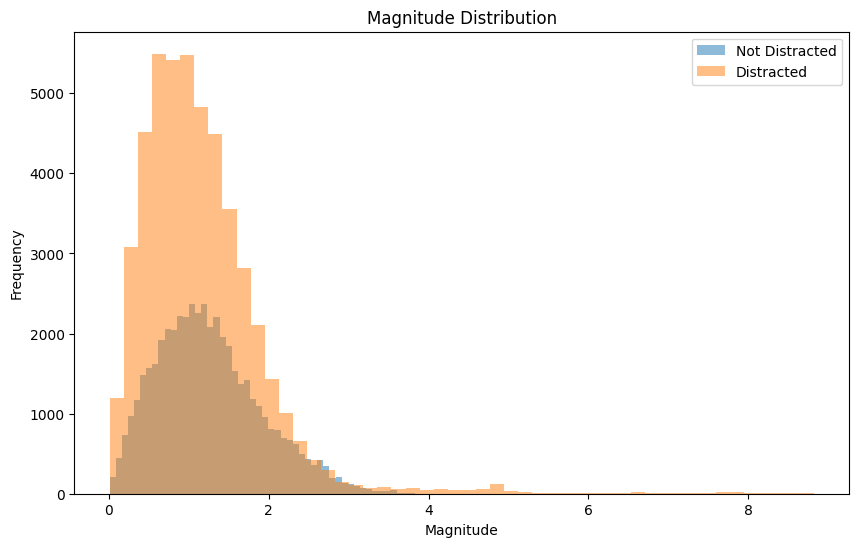

In [ ]:
# compute the magnitude of X_not_distracted
magnitude_not_distracted = np.linalg.norm(X_not_distracted, axis=1)
magnitude_distracted = np.linalg.norm(X_test, axis=1)

print(min(magnitude_not_distracted), max(magnitude_not_distracted))
print(min(magnitude_distracted), max(magnitude_distracted))

# print the histograms 
plt.figure(figsize=(10, 6))
plt.hist(magnitude_not_distracted, bins=50, alpha=0.5, label='Not Distracted')
plt.hist(magnitude_distracted, bins=50, alpha=0.5, label='Distracted')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Magnitude Distribution')
plt.legend()
plt.show()


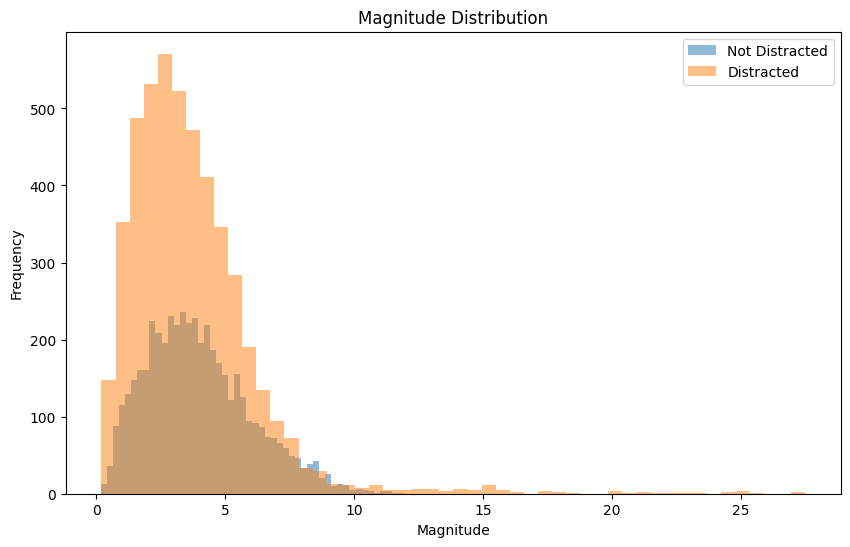

In [ ]:
window_size = 10

# Reshape the data into windows of size 150 samples (ensure the number of samples is divisible by 150)
X_not_distracted_windows = X_not_distracted[:len(X_not_distracted) - len(X_not_distracted) % window_size].reshape(-1, window_size, X_not_distracted.shape[1])
X_test_windows = X_test[:len(X_test) - len(X_test) % window_size].reshape(-1, window_size, X_test.shape[1])

# Compute the magnitude for each window
magnitude_not_distracted = np.linalg.norm(X_not_distracted_windows, axis=(1, 2))
magnitude_distracted = np.linalg.norm(X_test_windows, axis=(1, 2))

plt.figure(figsize=(10, 6))
plt.hist(magnitude_not_distracted, bins=50, alpha=0.5, label='Not Distracted')
plt.hist(magnitude_distracted, bins=50, alpha=0.5, label='Distracted')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Magnitude Distribution')
plt.legend()
plt.show()